In [12]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [13]:
import torch
import torch.nn as nn
import torch.utils.data
import matplotlib.pyplot as plt
import numpy as np
from torchvision import transforms
import torchvision.utils as vutils
from datasets import load_dataset
from src.CustomTransforms import FromHxWxC_To_CxHxW

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"pytorch running on {device}")

pytorch running on cuda


## Create PyTorch dataset from huggingface dataset

In [14]:
dataset = load_dataset("diffusers/pokemon-gpt4-captions")
dataset = dataset.with_format(type='torch', columns=['image', 'text'])
display(dataset)

DatasetDict({
    train: Dataset({
        features: ['image', 'text'],
        num_rows: 833
    })
})

In [15]:
from src.Dataloader import ImageHuggingfaceDataset

transform = transforms.Compose([
    FromHxWxC_To_CxHxW(),
    transforms.ToPILImage(),
    transforms.Resize((128, 128)),
    transforms.ToTensor()
])
ds_train = ImageHuggingfaceDataset(dataset['train'], label='text', category='image', transform=transform)

In [16]:
example = ds_train[0]
print(example[0].shape)

torch.Size([3, 128, 128])


In [17]:
dl_train = torch.utils.data.DataLoader(ds_train, batch_size=64, shuffle=True, num_workers=4)

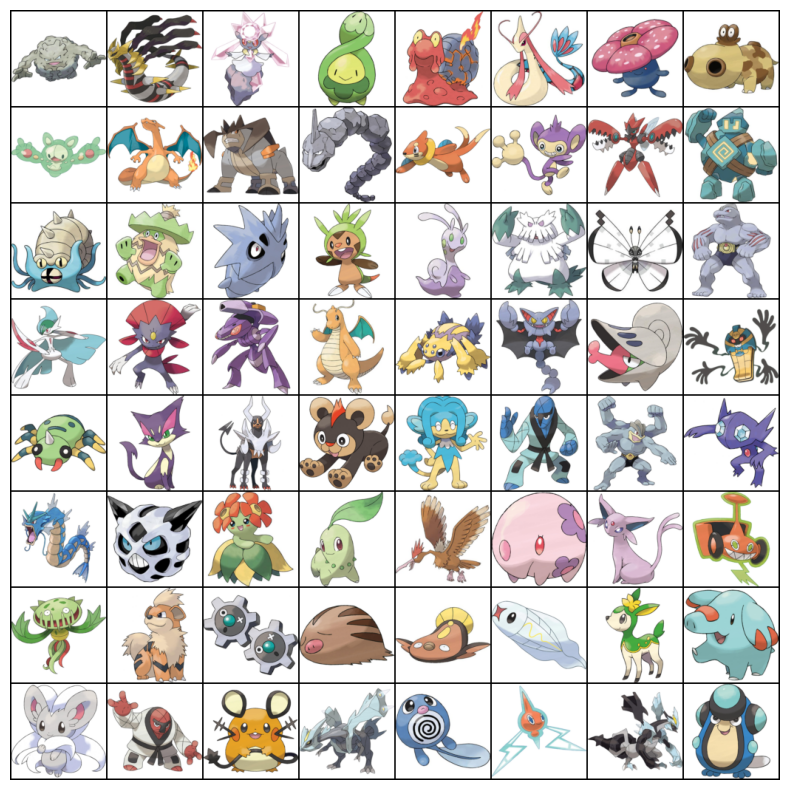

In [18]:
# Get a batch of images from the DataLoader
dataiter = iter(dl_train)
images, _ = next(dataiter)

# Create a grid of images
grid = vutils.make_grid(images, padding=2, normalize=True)

# Transpose the tensor from CxHxW to HxWxC
grid = np.transpose(grid, (1, 2, 0))

# Display the images
plt.figure(figsize=(10, 10))
plt.imshow(grid)
plt.axis('off')
plt.show()

### Istantiate generator and discriminator


In [19]:
from src.Model.Generator import Generator

nz = 100
image_size = 128
nc = 3
ngf = 128
generator = Generator(nz, ngf, nc).to(device)
generator.init_weights()

In [20]:
# test the generator inference
noise = torch.randn(64, nz, 1, 1, device=device)
fake = generator(noise)
print(fake.shape)

torch.Size([64, 3, 128, 128])


In [21]:
from src.Model.Discriminator import Discriminator

ndf = 128
discriminator = Discriminator(nc, ndf).to(device)
discriminator.init_weights()

In [22]:
# test the discriminator inference
output = discriminator(fake)
print(output.shape)

torch.Size([64, 1, 1, 1])


## Training the GAN

In [23]:
num_epochs = 5

criterion = nn.BCELoss()

fixed_noise = torch.randn(128, nz, 1, 1, device=device)

real_label = 1
fake_label = 0

# Setup Adam optimizers for both G and D
lr = 0.0002
beta1 = 0.5
optimizerD = torch.optim.Adam(discriminator.parameters(), lr=lr, betas=(beta1, 0.999))
optimizerG = torch.optim.Adam(generator.parameters(), lr=lr, betas=(beta1, 0.999))


In [24]:
# Training Loop

# Lists to keep track of progress
img_list = []
G_losses = []
D_losses = []
iters = 0

print("Starting Training Loop...")
# For each epoch
for epoch in range(num_epochs):
    # For each batch in the dataloader
    for i, data in enumerate(dl_train, 0):

        ############################
        # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
        ###########################
        ## Train with all-real batch
        discriminator.zero_grad()
        # Format batch
        real_cpu = data[0].to(device)
        b_size = real_cpu.size(0)
        label = torch.full((b_size,), real_label, dtype=torch.float, device=device)
        # Forward pass real batch through D
        output = discriminator(real_cpu).view(-1)
        # Calculate loss on all-real batch
        errD_real = criterion(output, label)
        # Calculate gradients for D in backward pass
        errD_real.backward()
        D_x = output.mean().item()

        ## Train with all-fake batch
        # Generate batch of latent vectors
        noise = torch.randn(b_size, nz, 1, 1, device=device)
        # Generate fake image batch with G
        fake = generator(noise)
        label.fill_(fake_label)
        # Classify all fake batch with D
        output = discriminator(fake.detach()).view(-1)
        # Calculate D's loss on the all-fake batch
        errD_fake = criterion(output, label)
        # Calculate the gradients for this batch, accumulated (summed) with previous gradients
        errD_fake.backward()
        D_G_z1 = output.mean().item()
        # Compute error of D as sum over the fake and the real batches
        errD = errD_real + errD_fake
        # Update D
        optimizerD.step()

        ############################
        # (2) Update G network: maximize log(D(G(z)))
        ###########################
        generator.zero_grad()
        label.fill_(real_label)  # fake labels are real for generator cost
        # Since we just updated D, perform another forward pass of all-fake batch through D
        output = discriminator(fake).view(-1)
        # Calculate G's loss based on this output
        errG = criterion(output, label)
        # Calculate gradients for G
        errG.backward()
        D_G_z2 = output.mean().item()
        # Update G
        optimizerG.step()

        # Output training stats
        if i % 50 == 0:
            print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
                  % (epoch, num_epochs, i, len(dl_train),
                     errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))

        # Save Losses for plotting later
        G_losses.append(errG.item())
        D_losses.append(errD.item())

        # Check how the generator is doing by saving G's output on fixed_noise
        if (iters % 500 == 0) or ((epoch == num_epochs-1) and (i == len(dl_train)-1)):
            with torch.no_grad():
                fake = generator(fixed_noise).detach().cpu()
            img_list.append(vutils.make_grid(fake, padding=2, normalize=True))

        iters += 1

Starting Training Loop...
[0/5][0/14]	Loss_D: 2.4183	Loss_G: 14.7666	D(x): 0.3337	D(G(z)): 0.4624 / 0.0000
[1/5][0/14]	Loss_D: 0.0000	Loss_G: 58.4529	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000
[2/5][0/14]	Loss_D: 0.0000	Loss_G: 58.4246	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000
[3/5][0/14]	Loss_D: 0.0000	Loss_G: 58.5251	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000
[4/5][0/14]	Loss_D: 0.0000	Loss_G: 58.8393	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


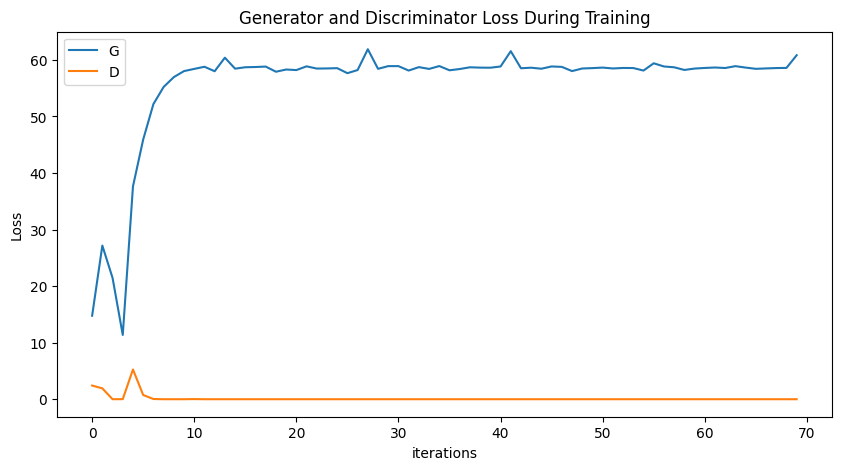

In [25]:
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses,label="G")
plt.plot(D_losses,label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

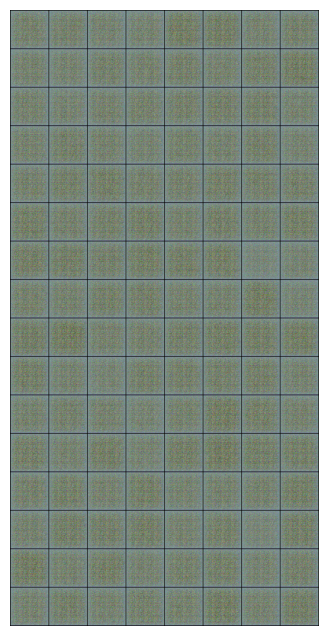

In [26]:
fig = plt.figure(figsize=(8,8))
plt.axis("off")
ims = [[plt.imshow(np.transpose(i,(1,2,0)), animated=True)] for i in img_list]
